<a href="https://colab.research.google.com/github/Son-Of-Fry/ProyectoIntegrador/blob/main/Avance4_64Equipo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Parte 3: Modelo Final
por José Ricardo Munguía Marín

**NOTA Importante: El proyecto completo, con los archivos py y contenedores, se encuentran en el git. Esté es un resumen del avance, no el proyecto en sí.**

Galu Guard es un proyecto que lo podemos definir como una plataforma tecnológica modular, portable y abierta, diseñada para facilitar la adopción de la visión artificial en entornos reales. Por lo que, más que un modelo de ML, Galu Guard se considera mśa un software ML OPS, o IA Ops.


Consolidando lo estudiado y analizado, se considera lo siguiente como sus herramientas principales como parte de esté modelo final:

- El sistema utiliza como base el algoritmo de detección de objetos YOLO v11 tamaño s, basado en las mejoras que se detectaron contra la v8 en la entrega anterior.

- Para la interfaz gráfica se seleccionó Qt, dada su flexibilidad y potencia visual, permitiendo unificar múltiples funciones en un entorno amigable.

- La contenedorización con Docker refuerza la portabilidad y la uniformidad del despliegue, un pilar fundamental para un sistema destinado a robots, drones o centros de monitoreo.


Este enfoque unificado cumple con dos objetivos clave: escalabilidad e instalación simplificada. Todo el sistema se ejecuta en un único contenedor con soporte GPU, con una interfaz que se visualiza en el host mientras el procesamiento permanece encapsulado en un contenedor.

Este diseño sigue las mejores prácticas de ML Ops y desarrollo modular.

## Primera Parte: Módulos Funcionales Clave

La primera parte del avance y del modelo final se centró en componentes esenciales para robustecer el sistema:

- Launcher: Actúa como panel de control central, permitiendo al usuario lanzar los distintos módulos.

- configuración: Es una barra de opciones, para decidir que cámara, modelo y clases detectar. Así como el nivel de confianza.

- Reportador: Una interfaz visual para revisar detecciones anteriores, organizadas cronológicamente, facilitando la trazabilidad y validación.

- Deduplicador: Herramienta de filtrado que limpia detecciones repetidas, mejorando la precisión y optimizando el almacenamiento.



Estos módulos, organizados bajo la estructura de Qt, operan de forma interdependiente pero modular, facilitando el mantenimiento y futuras expansiones.

estructura de lsa  carpetas

    Galu_guard_contenedor/
    ├── camera_yolo_1.py         # Detección y visualización en tiempo real
    ├── configurator.py          # Interfaz Qt para configurar cámaras y parámetros
    ├── deduplicator.py          # Filtro de eventos duplicados en logs
    ├── dockerfile               # Imagen Docker con todo el entorno
    ├── correr.sh                # Script para lanzar contenedor con soporte GPU y GUI
    ├── config.json              # Archivo de configuración central (modelo, clases, etc.)
    ├── launcher.py              # Ventana principal con acceso a todos los módulos
    ├── reportador.py            # Visualizador de eventos pasados con interfaz Qt
    ├── logs/                    # Carpeta donde se almacenan imágenes y datos de detecciones


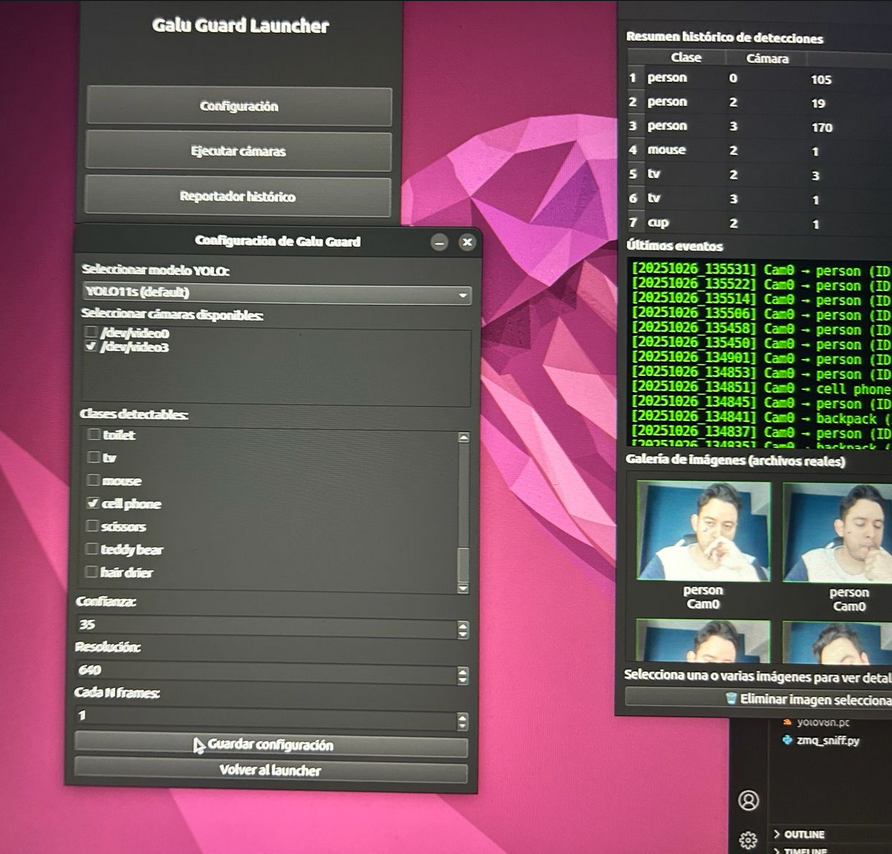


Cofiguraador.py

#Segunda Parte: Pruebas de Detección en Patrullaje
Los robots Go2 edición Pro y Edu cuentan con una solución completa en tema de patrullaje con una Lidar propia. Si embargo, la cámara principal actua como fondo de los controles. Por lo que se pueden añadir nuevas cámaras para evitar estas señales.

Está práctica visual, tiene como objetivo vincular está cámara nativa, para no depender todo el tiempo de un equipo superior.



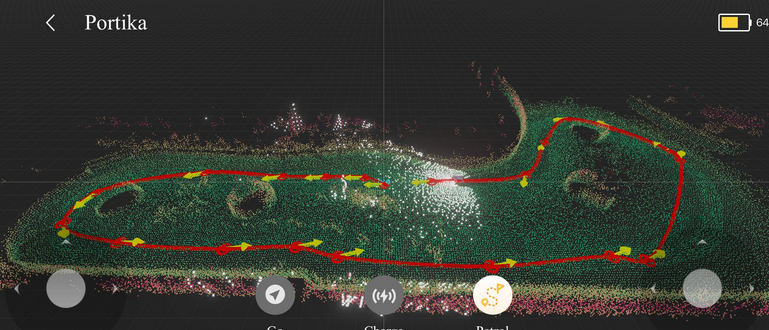

Mapeo de una pista de carrera en una residencia.

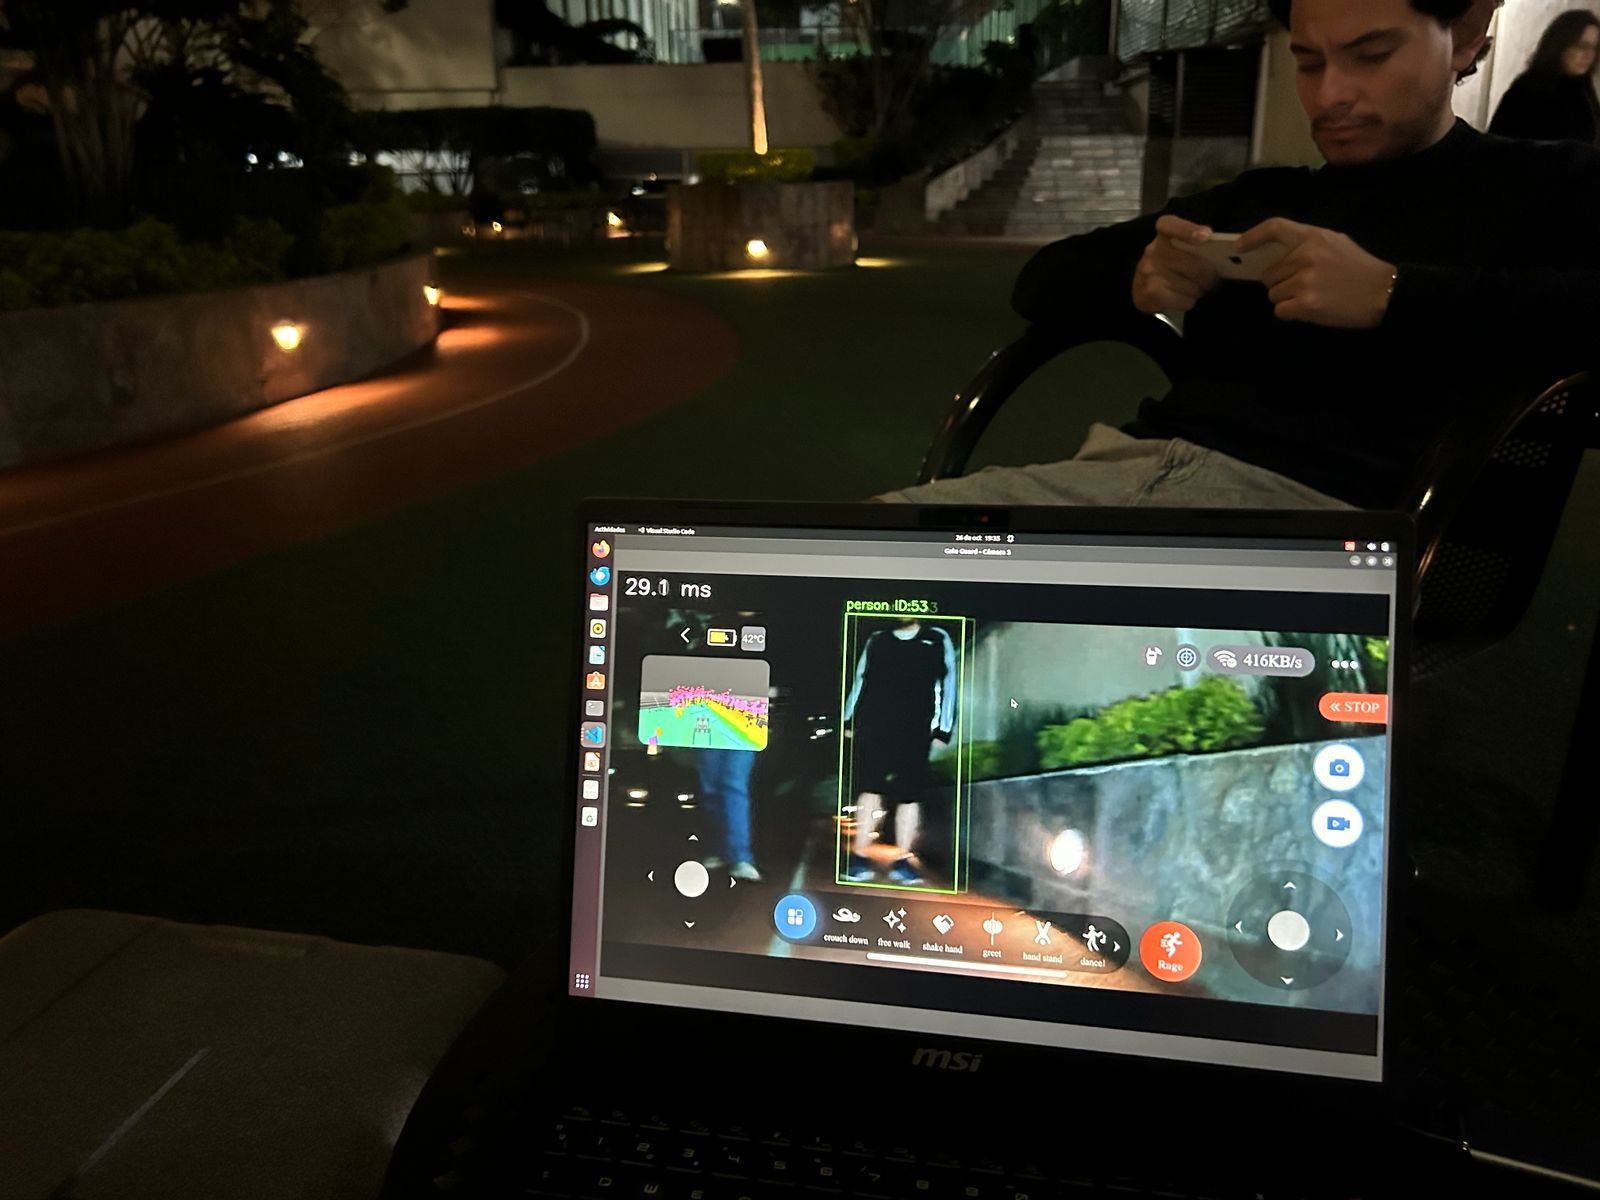
analisis del video mientras está en el modo patrulla.

La información generada (imágenes, metadatos y registros) se almacenó automáticamente en la carpeta logs/ en csv. Estos datos pueden ser vizualizados posteriormente con el reportador del launcher (que es otra ventana Qt) demostrando una integración completa del ciclo de captura, análisis y visualización.

En esta etapa también se validó la flexibilidad del sistema mediante el archivo config.json, ajustando clases a detectar, umbrales de confianza y el modelo YOLO11s, todo ajustando desde la ventana de Qt de configuración.

Tercera Parte: Contenerización con Soporte NVIDIA y Despliegue
La parte técnica más compleja, fue la deencapsular la aplicación en un contenedor Docker manteniendo la aceleración por GPU (CUDA) y permitiendo que la interfaz Qt se ejecutara en el host. Dado que Docker no está diseñado nativamente para entornos gráficos, fue necesario implementar el NVIDIA Container Toolkit.

nuevo contenedor:

    FROM pytorch/pytorch:2.2.2-cuda11.8-cudnn8-runtime

    WORKDIR /app

    RUN apt update && apt install -y \
        libgl1-mesa-glx \
        libx11-6 \
        qtbase5-dev \
        libxcb-cursor0 \
        && apt clean

    COPY . /app

    RUN pip install --no-cache-dir \
        "numpy<2" \
        opencv-python \
        ultralytics \
        PySide6

    CMD ["python", "launcher.py"]


De esta forma, se aseguró una contención completa de Qt acelerada por GPU.

para poder ejecutar el contenedor, se deben de otorgar por permisos de acceso a las cámaras, x11 para el qt y acceso a la Cuda de la GPU.

    docker run -it --rm     
    --name qt-yolo     
    --gpus all     
    --device /dev/video0:/dev/video0     
    --privileged     
    -e DISPLAY=$DISPLAY     
    -v /tmp/.X11-unix:/tmp/.X11-unix     
    -v $(pwd):/app     
    qt-yolo


El resultado es un entorno portable, reproducible y de fácil instalación, gestionado por un script (correr.sh) y un acceso directo .desktop, permitiendo su ejecución en cualquier sistema con drivers NVIDIA. Preferiblemente **UBUNTU 20.04**.

##Conclusión

Galu Guard ha evolucionado de una prueba de concepto a un sistema modular con una arquitectura moderna. Su diseño basado en Qt, procesamiento en contenedor con acceso a aceleración por GPU yel  uso de herramientas como YOLO, otorga una Base para seguir expandiendo con nuevos modelos de detección, realizando entrenamientos completos o simples ajustes finos a modelos ya concluidos de Yolo por ejemplo.


Próximas etapas:

- Su futuro inmediato contempla la integración de video por red (RTSP).
- Se creará un servidor en una Jetson Orin Nano, con la intención de migrar a un ambiente de producción completo, con hardware dedicado.
- se intentará crear la versión Edge 100%, es decir, montar una Jetson Orin Nano, con una cámara conectada nativa y aislada, mandando datos en tiempo real ya analizados sobre detección a un servicio en línea.
